In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:
import numpy as np
import pandas as pd

import edhec_risk_kit_202 as erk

In [3]:
ind = erk.get_ind_returns()["2000":]

Construct a manager that invests in 30% Beer, 50% in Smoke and 20% in other things that have an average return of 0% and an annualized vol of 15%:

In [4]:
mgr_r = 0.3*ind["Beer"] + 0.5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5), size=ind.shape[0])

In [5]:
weights = erk.style_analysis(mgr_r, ind)*100

<Axes: >

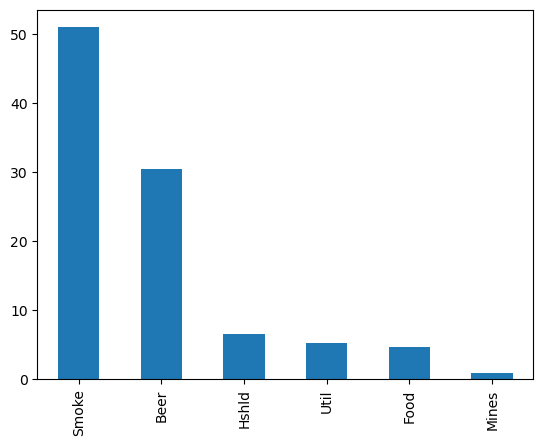

In [6]:
weights.sort_values(ascending=False).head(6).plot.bar()

In [7]:
coeffs = erk.regress(mgr_r, ind).params*100
coeffs.sort_values().head()

Rtail   -3.576097
Whlsl   -2.729026
ElcEq   -1.831363
Games   -1.781258
Hlth    -1.526117
dtype: float64

<Axes: >

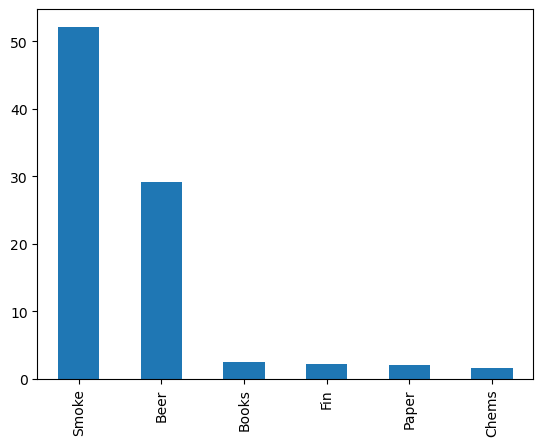

In [8]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

In [10]:
#!pip install yfinance
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Style Drift: Time-Varying Exposures with Sharpe Style Analysis

Sharpe Style Analysis can also be used to track how a fund’s exposures evolve over time.  
By applying the analysis over a rolling window (e.g. 3–5 years), it is possible to estimate  
time-varying weights and visualize *style drift* - shifts in a manager’s effective bets.

In this example, I analyze **QQQ** (Nasdaq-100 ETF) using a set of building block ETFs such as  
Growth (SPYG), Value (SPYV), Small-Cap (IWM), Large-Cap (OEF), sector funds (XLK, XLY, XLC),  
and the broad market (SPY). This approach is similar in spirit to Morningstar’s "style box"  
and the Fama–French factor models.

The rolling analysis highlights QQQ’s persistent tilt toward **Technology** and **Growth**,  
with changes in exposures reflecting market conditions over time.


QQQ style weights (%):
XLK     51.97
SPYG    24.41
XLY     12.36
XLC     11.25
IWM      0.00
OEF      0.00
SPYV     0.00
SPY      0.00
dtype: float64

Tracking Error (monthly): 0.0099
Style R^2: 0.961


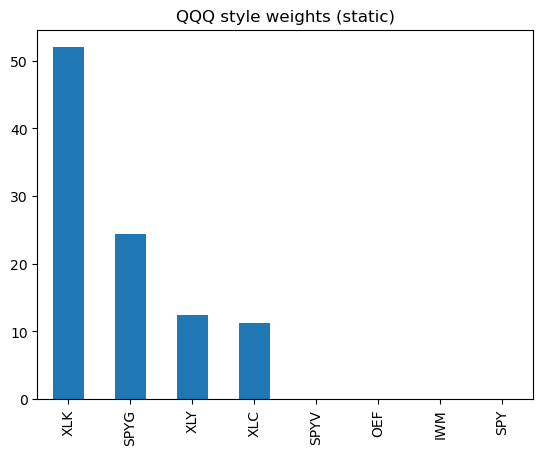

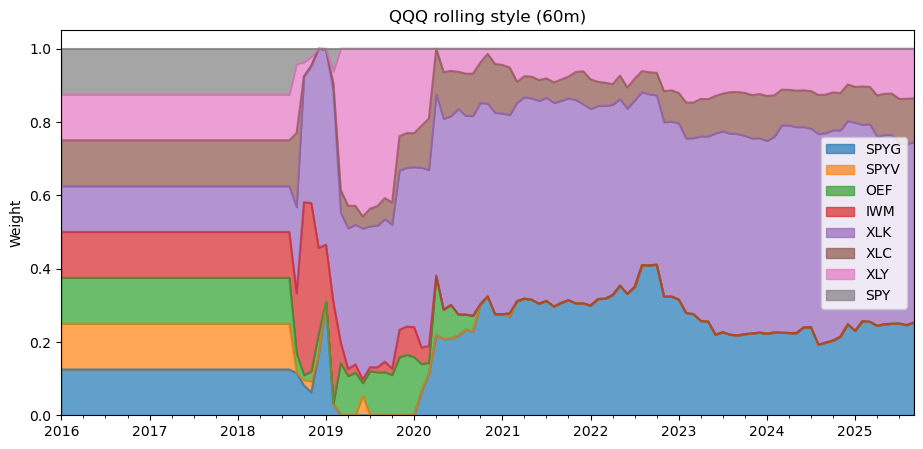

In [12]:
mgr_ticker = "QQQ"
bb_tickers = ["SPYG","SPYV","OEF","IWM","XLK","XLC","XLY","SPY"]  # add a few sectors + broad market
tickers = bb_tickers + [mgr_ticker]

raw = yf.download(tickers, start="2010-01-01", progress=False, auto_adjust=True)

# handle yfinance MultiIndex (('Close','QQQ'), etc.)
prices = raw["Close"] if isinstance(raw.columns, pd.MultiIndex) else raw
# monthly returns; silence the FutureWarning explicitly
rets = prices.resample("M").last().pct_change(fill_method=None).dropna(how="all")

bb   = rets[bb_tickers]
mgr  = rets[mgr_ticker]

def tracking_error(a, b): #Style analysis
    aligned = pd.concat([a, b], axis=1).dropna()
    return aligned.iloc[:,0].sub(aligned.iloc[:,1]).std()

def portfolio_tracking_error(w, ref, B):
    w = np.asarray(w)
    aligned = pd.concat([ref, B], axis=1).dropna()
    r = aligned.iloc[:,0]
    M = aligned.iloc[:,1:]
    port = (M.values @ w)
    return (r.values - port).std()

def style_analysis(ref, B):
    aligned = pd.concat([ref, B], axis=1).dropna()
    r = aligned.iloc[:,0]
    M = aligned.iloc[:,1:]
    n = M.shape[1]
    x0 = np.repeat(1/n, n)
    bounds = [(0,1)]*n
    cons = [{'type':'eq','fun': lambda w: np.sum(w)-1}]
    res = minimize(portfolio_tracking_error, x0, args=(r, M), method="SLSQP",
                   bounds=bounds, constraints=cons, options={'maxiter':500})
    return pd.Series(res.x, index=M.columns)

w = style_analysis(mgr, bb)
fitted = (bb * w).sum(axis=1)

te = tracking_error(mgr, fitted)
r2_style = 1 - (mgr.sub(fitted)).var() / mgr.var()

print("QQQ style weights (%):")
print((w*100).round(2).sort_values(ascending=False))
print(f"\nTracking Error (monthly): {te:.4f}")
print(f"Style R^2: {r2_style:.3f}")

(w*100).sort_values(ascending=False).head(8).plot.bar(title="QQQ style weights (static)")
plt.show()

window = 60 #Rolling 60-month style drift
dates, rows = [], []
for i in range(window, len(mgr)):
    w_i = style_analysis(mgr.iloc[i-window:i], bb.iloc[i-window:i])
    rows.append(w_i)
    dates.append(mgr.index[i])
W = pd.DataFrame(rows, index=dates)

# trim early unstable estimates before plotting
W.loc["2016":].plot.area(figsize=(11,5), alpha=0.7, title="QQQ rolling style (60m)")
plt.ylabel("Weight"); plt.xlabel("")
plt.show()


### Interpreting the Style Analysis Results

**Static Style Weights (bar chart)**  
The static analysis shows that QQQ’s returns can be closely replicated by a portfolio that is:  
- **Tech-heavy (XLK ~50%)**  
- **Growth-tilted (SPYG ~25%)**  
- With smaller exposure to **Consumer Discretionary (XLY ~12%)** and **Communication Services (XLC ~11%)**  

Other factors (Value, Small Cap, Broad Market) contribute very little.  
This aligns with QQQ’s structure as a tech- and growth-dominated index.  

**Rolling Style Drift (area chart)**  
The rolling window analysis reveals how these exposures evolved over time:  
- **Pre-2018:** weights are unstable and spread across multiple ETFs (an artifact of limited data and overlapping benchmarks).  
- **2019 onward:** exposures stabilize, with QQQ showing a persistent **Technology + Growth tilt**.  
- Secondary contributions come from **XLY (Amazon, Tesla)** and **XLC (Google, Meta)**, reflecting sector concentrations within QQQ.  

**Summary:** QQQ has consistently behaved like a **growth/tech fund**, with minor sector rotations over time. The early-window estimates should be treated cautiously.
